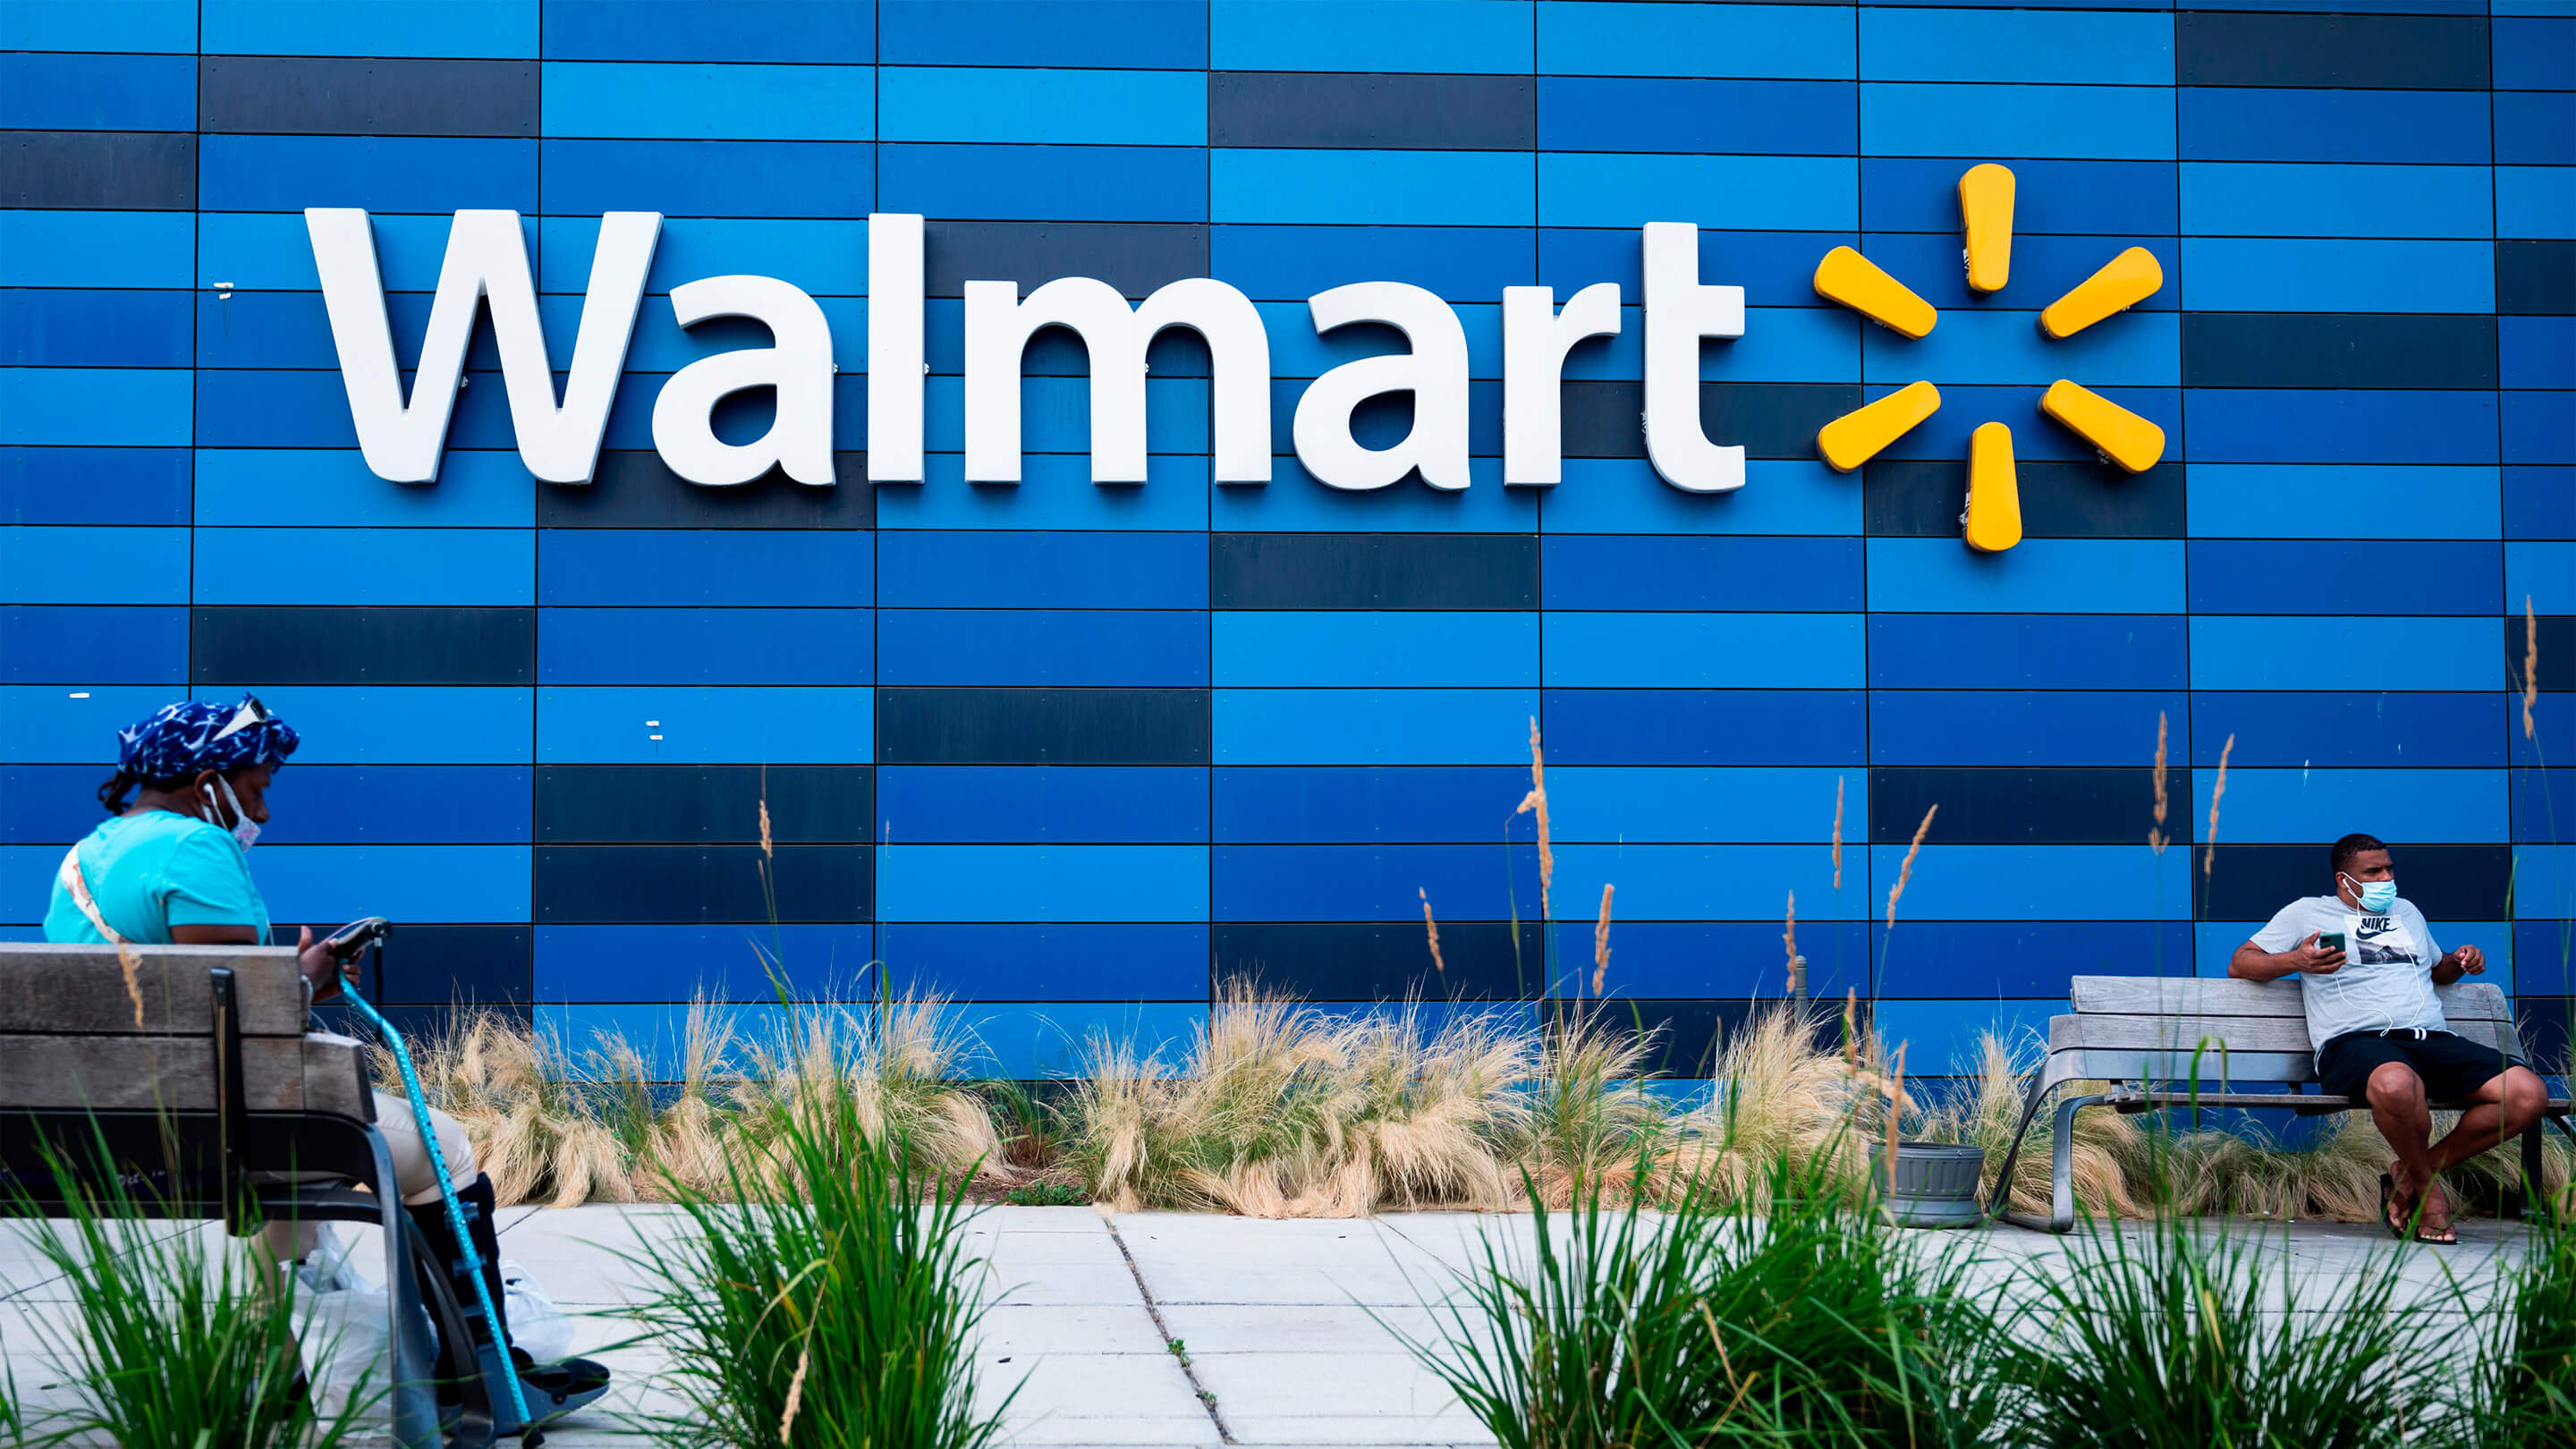

## <span style="color:DarkCyan;">  Introduction </span>

**This notebook is created as summer project MSc Students in Business Analytics and Data Science of the University of Macedonia**

### <span style="color:DarkCyan;">The M5 Forecasting:Accuracy Competition </span>

Walmart Inc. is an American multinational retail corporation that operates a chain of hypermarkets, discount department stores, and grocery stores, headquartered in Bentonville, Arkansas.The company was founded by Sam Walton in 1962 and incorporated on October 31, 1969. As of July 31, 2020, Walmart has 11,496 stores and clubs in 27 countries, operating under 56 different names.[2][3][13] The company operates under the name Walmart in the United States and Canada, as Walmart de México y Centroamérica in Mexico and Central America, as Asda in the United Kingdom, as the Seiyu Group in Japan, and as Flipkart Wholesale in India. It has wholly owned operations in Argentina, Chile, Canada, and South Africa.

At the beginning of 2020, MOFC organised this competition.In this competition, the fifth iteration, we will use hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

**<span style="color:DarkCyan;"> Objectives </span>**

The objective of the M5 forecasting competition is to advance the theory and practice of forecasting by identifying the method(s) that provide the most accurate point forecasts for each of the 42,840 time series of the competition. I addition, to elicit information to estimate the uncertainty distribution of the realized values of these series as precisely as possible.

## <span style="color:DarkCyan;">  Importing essential libraries </span>

In [62]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np #linear alebra
import pandas as pd #data manipulation

#plotting
import plotly as py
import plotly.graph_objs as go
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
cf.set_config_file(offline=True)
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
#filter warnings
import warnings
warnings.filterwarnings('ignore')

#modelling and preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
import joblib

#get insights
from statsmodels.tsa.seasonal import seasonal_decompose #find seasonality,trends etc
from scipy.stats import pearsonr



/kaggle/input/rainfall2/California.xlsx
/kaggle/input/rainfall2/WisconsinExcel.xlsx
/kaggle/input/rainfall2/TexasExcel.xlsx
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [63]:
# display all the columns in the dataset
pd.pandas.set_option('display.max_columns', None)

## <span style="color:DarkCyan;">  Loading the Data </span>

In [64]:
# Load the Data
train= pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
sample = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")
tx_rain=pd.read_excel('../input/rainfall2/TexasExcel.xlsx') # rainfall in Texas
cal_rain=pd.read_excel('../input/rainfall2/California.xlsx') # rainfall in California
wi_rain=pd.read_excel('../input/rainfall2/WisconsinExcel.xlsx') # rainfall in Winsconsin

## <span style="color:DarkCyan;">  Inspect Data </span>

In [65]:
print("train:",train.shape,",","calendar:",calendar.shape,",","sell_prices:",sell_prices.shape,",","sample:",sample.shape,)

train: (30490, 1947) , calendar: (1969, 14) , sell_prices: (6841121, 4) , sample: (60980, 29)


In [66]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [67]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [68]:
train.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [69]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [70]:
# merge the rainfall datasets 
rain_final=tx_rain.merge(wi_rain,on='date').merge(cal_rain,on='date')
rain_final['date']=rain_final['date'].astype(str)
rain_final.head()

,date,rainfall_texas(mm),rainfall_wisconsin(mm),rainfall_cal(mm)
0,2011-01-29,0.06383,0.0,0.0
1,2011-01-30,0.35653,0.0,7.2
2,2011-01-31,0.65826,1.6,0.0
3,2011-02-01,7.83312,2.7,0.0
4,2011-02-02,0.00025,3.4,0.0


In [71]:
# merge calendar and rainfall datasets 
calendar=pd.merge(calendar,rain_final, on='date',how='left')
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,rainfall_texas(mm),rainfall_wisconsin(mm),rainfall_cal(mm)
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0.06383,0.0,0.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0.35653,0.0,7.2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0.65826,1.6,0.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,7.83312,2.7,0.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0.00025,3.4,0.0


In [72]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


**<span style="color:DarkCyan;">  Check for null values </span>**

In [73]:
train.isnull().any()

id          False
item_id     False
dept_id     False
cat_id      False
store_id    False
            ...  
d_1937      False
d_1938      False
d_1939      False
d_1940      False
d_1941      False
Length: 1947, dtype: bool

In [74]:
calendar.isnull().sum().sort_values(ascending = False)

event_type_2              1964
event_name_2              1964
event_type_1              1807
event_name_1              1807
d                            0
wm_yr_wk                     0
weekday                      0
wday                         0
month                        0
year                         0
rainfall_cal(mm)             0
rainfall_wisconsin(mm)       0
snap_CA                      0
snap_TX                      0
snap_WI                      0
rainfall_texas(mm)           0
date                         0
dtype: int64

event_type_2,event_name_2,event_type_1,event_name_1 has several na values as observed

**<span style="color:DarkCyan;">  Add zeros to the days we are going to predict(1942-1969) </span>**

In [75]:
#To get the days we are trying to predict(28 days)
for i in range(1942,1970):
    col = "d_"+ str(i)
    train[col] = 0

In [76]:
#Let's make a list of day columns as day_col = [d1,d2,d3,d4...] for the visualisations
day_col = [col for col in train if col.startswith('d_')]

## <span style="color:DarkCyan;">  Exploratory Data Analysis </span>

In [77]:
#Lets look at the number of rows for each state. Value_counts give you that
train.state_id.value_counts()

CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64

In [78]:
#Let's have a look at the ratio of the number of rows. Normalize = True gives the ratio
train.state_id.value_counts(normalize =True) 

CA    0.4
TX    0.3
WI    0.3
Name: state_id, dtype: float64

40%,30%,30% of the rows of the selected items are about California,Wisconsin and Texas respectively.

**<span style="color:DarkCyan;">  Sales of each State </span>**

In [79]:
#Calculating total sales for each row/ id by adding the sales of each of the 1913 days
train['sales'] = train[day_col].sum(axis=1)
train['sales']
#Adding all the sales for each state
train.groupby('state_id').agg({"sales":"sum"}).reset_index()

,state_id,sales
0,CA,29196717
1,TX,19228405
2,WI,18502051


**<span style="color:DarkCyan;">  Plotting Sales Ratio across the states </span>**


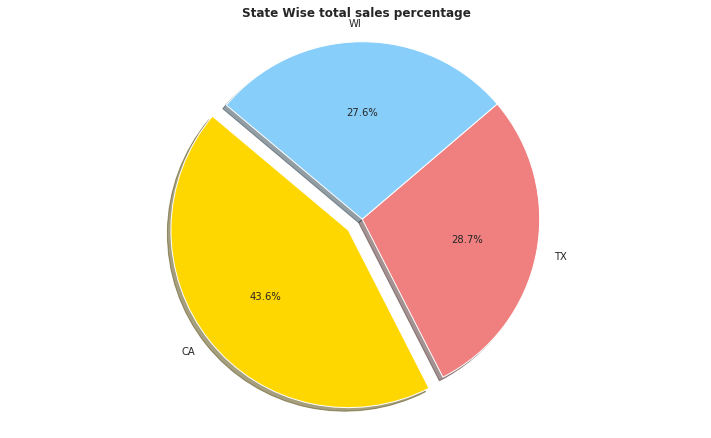

In [80]:
#Calculating the sales ratio: (state sales/total sales)
sales_by_state = train.groupby('state_id').agg({"sales":"sum"})/train.sales.sum() * 100
sales_by_state = sales_by_state.reset_index()
#plotting
explode = (0.1, 0, 0)  # explode 1st slice
colors = ['gold', 'lightcoral', 'lightskyblue']
fig1, ax1 = plt.subplots()
ax1.pie(sales_by_state['sales'],explode=explode,labels= sales_by_state['state_id'],colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax1.axis('equal')  
plt.title("State Wise total sales percentage",fontweight="bold")
fig1.set_size_inches(12.5, 7.5)
plt.show()

We can see that 43.6% of sales come from California while Texas and Winscoin have comparable percentages of 28.7% and 27.6% of the sales respectively.

**<span style="color:DarkCyan;">  Plotting Sales Ratio across the stores </span>**

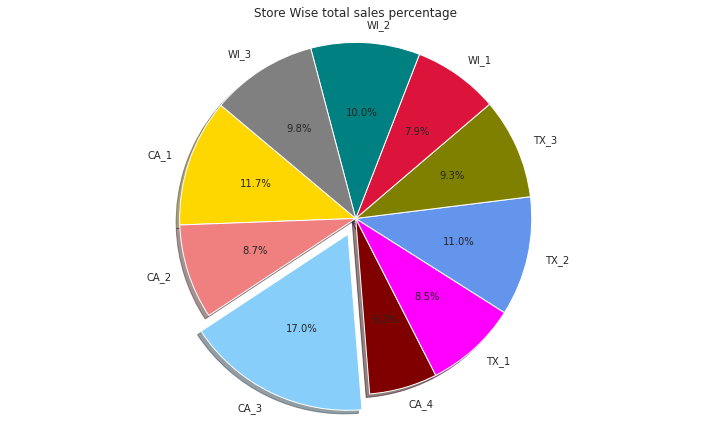

In [81]:
#Calculating the sales ratio: store sales/total sales
sales_by_store = train.groupby('store_id').agg({"sales":"sum"})/train.sales.sum() * 100
sales_by_store = sales_by_store.reset_index()
#plotting
explode = (0, 0, 0.1,0,0,0,0,0,0,0)  # explode 1st slice
colors = ['gold', 'lightcoral', 'lightskyblue','maroon','magenta','cornflowerblue','olive','crimson','teal','grey'] #colors from: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
fig1, ax1 = plt.subplots()
ax1.pie(sales_by_store['sales'],explode=explode,labels= sales_by_store['store_id'],colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax1.axis('equal')  
plt.title("Store Wise total sales percentage")
fig1.set_size_inches(12.5, 7.5)
plt.show()

The highest sales ratio belongs to the CA_3 store with 17%, while the lowest belongs to CA_4 store with a sales ratio of just 6.2%

**<span style="color:DarkCyan;">  Total sales across categories </span>**

In [82]:
#Let's have a look at the total sales from each of the 3 categories
print("Total Sales from each category")
train.groupby('cat_id').agg({"sales":"sum"}).reset_index()

Total Sales from each category


,cat_id,sales
0,FOODS,45922427
1,HOBBIES,6240656
2,HOUSEHOLD,14764090


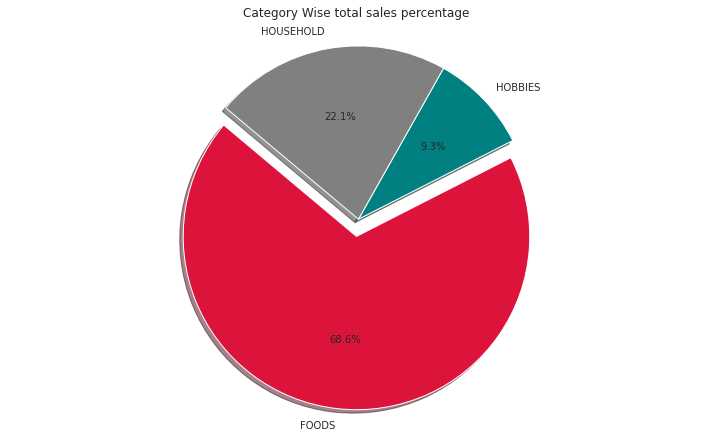

In [83]:
#Calculating the sales ratio: store sales/total sales
sales_by_category = train.groupby('cat_id').agg({"sales":"sum"})/train.sales.sum() * 100
sales_by_category = sales_by_category.reset_index()

#plotting
explode = (0.1,0,0)  # explode 1st slice
colors = ['crimson','teal','grey'] #colors from: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
fig1, ax1 = plt.subplots()
ax1.pie(sales_by_category['sales'],explode=explode,labels= sales_by_category['cat_id'],colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
ax1.axis('equal')  
plt.title("Category Wise total sales percentage")
fig1.set_size_inches(12.5, 7.5)
plt.show()

Almost 70 % of the sales come from FOODS,22.1% come from HOUSEHOLD and 9,3% comes from HOBBIES

**<span style="color:DarkCyan;">  Plotting Sales for each category of the three states </span>**

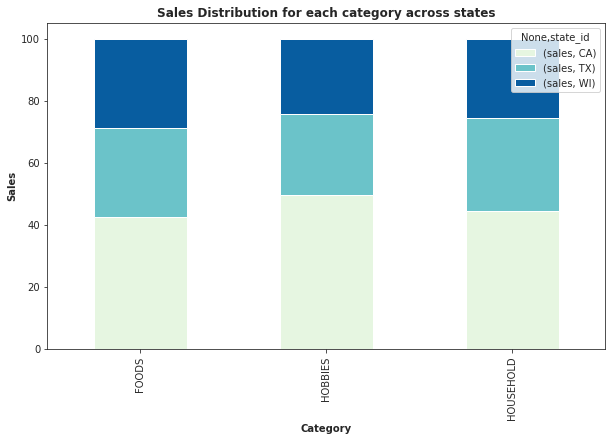

In [84]:
from matplotlib.colors import ListedColormap
sales_by_category_n_state =train.groupby(['cat_id','state_id']).agg({"sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack().plot(kind='bar', stacked=True,colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(10,6))
#ref: https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
#ref: https://stackoverflow.com/questions/47138271/how-to-create-a-stacked-bar-chart-for-my-dataframe-using-seaborn
plt.title("Sales Distribution for each category across states",fontweight = "bold")
plt.xlabel("Category",fontweight = "bold")
plt.ylabel("Sales",fontweight = "bold")
plt.show()

Based on the findings:

* California contributes to more than 40% sales of FOODS and of household  but contributes to more than 50% sales of HOBBIES category
* Wisconsin has about 25% contribution in HOUSEHOLD and HOBBIES categories  and about 30% of the sales in HOUSEHOLDin HOBBIES category

**<span style="color:DarkCyan;">  Plotting sales ditribution for each state across categories </span>**

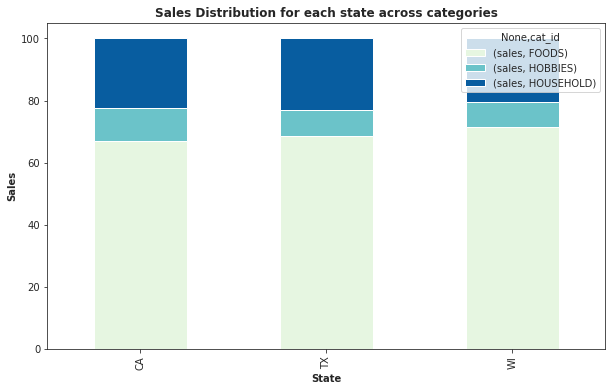

In [85]:
from matplotlib.colors import ListedColormap
sales_by_state_n_category =train.groupby(['state_id','cat_id']).agg({"sales":"sum"}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack().plot(kind='bar', stacked=True,colormap=ListedColormap(sns.color_palette("GnBu", 10)), 
          figsize=(10,6))
#ref: https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
#ref: https://stackoverflow.com/questions/47138271/how-to-create-a-stacked-bar-chart-for-my-dataframe-using-seaborn
plt.title("Sales Distribution for each state across categories",fontweight = "bold")
plt.xlabel("State",fontweight = "bold")
plt.ylabel("Sales",fontweight = "bold")
plt.show()

Based on the findings:

* Texas spends the highest in FOOD 70%, ~8% in HOBBIES and ~22% in HOUSEHOLD
* California spends ~67% in FOOD, ~11% in HOBBIES and 22% on HOUSEHOLD
* Wisconsin spends ~69% in FOOD, ~8% in HOBBIES and 23% in household 

Hence,it is obvious that there are 3 states differences across states spend-wise

**<span style="color:DarkCyan;">  Plotting sales ditribution department-wise </span>**

<span style="color:DarkCyan;">We have 7 departments( 2 for household, 2 for hobbies and 3 for foods) </span>

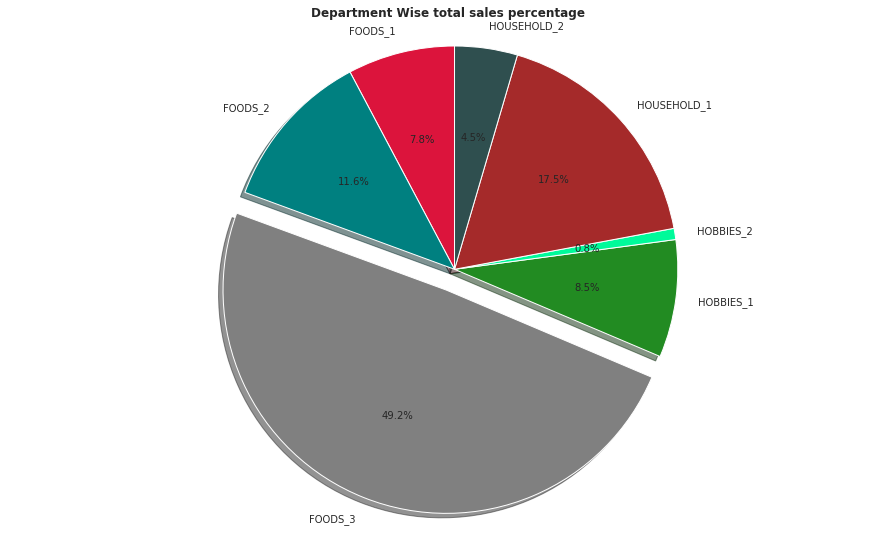

In [86]:
#Calculating sales distribution across departments
sales_by_department = train.groupby('dept_id').agg({"sales":"sum"})/train.sales.sum() * 100
#Plotting
explode = (0,0,0.1,0,0,0,0)  # explode 1st slice
colors = ['crimson','teal','grey','forestgreen','mediumspringgreen','brown','darkslategray'] #colors from: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
sales_by_department = sales_by_department.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(sales_by_department['sales'],explode=explode,labels= sales_by_department['dept_id'],colors=colors , autopct='%1.1f%%',
        shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.title("Department Wise total sales percentage",fontweight = "bold")
fig1.set_size_inches(12.5, 7.5)
plt.show()

* Almost 50% sales coming from FOODS_3 department which is the highest (total ~70% sales coming from FOODS)
* In HOUSEHOLD category, HOUSEHOLD_1 contributes to 17.5% to the total sales ( total ~22 % sales coming from HOUSEHOLD)
* In HOBBIES category,8.5% comes from HOBBIES_1 ( total 9.3% sales coming from HOBBIES)

**<span style="color:DarkCyan;"> Let's explore price data </span>**

Text(0.5, 1.0, 'Density plot of log of prices accross Categories')

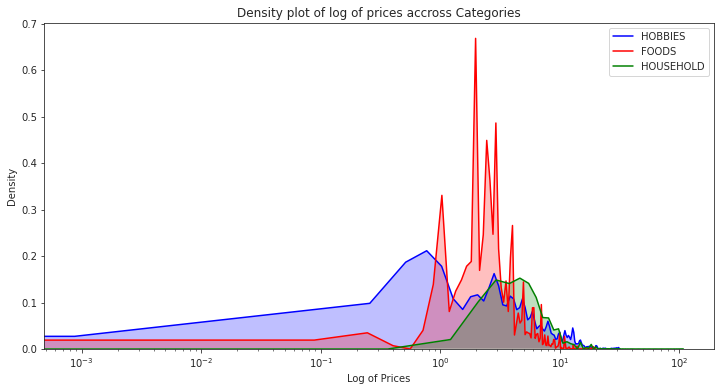

In [87]:
sell_prices["Category"] = sell_prices["item_id"].str.split("_",expand = True)[0]
plt.figure(figsize=(12,6))
p1=sns.kdeplot(sell_prices[sell_prices['Category']=='HOBBIES']['sell_price'], shade=True, color="b")
p2=sns.kdeplot(sell_prices[sell_prices['Category']=='FOODS']['sell_price'], shade=True, color="r")
p3=sns.kdeplot(sell_prices[sell_prices['Category']=='HOUSEHOLD']['sell_price'], shade=True, color="g")
plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")# We use log to make it easier to extract insights about the price,since too many data appear
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

**Insights:**

* We observe a high peak between 10^0 and 10^1 for FOODS.Hence,most of the prices for food products lie between 1 dollars and 10 dollars.
* Hobbies products show the  widest range of prices
* Household products appear more stable range wise than the other categories in matter of sell prices. They also appear costlier than FOOD and HOBBIES category.

**<span style="color:DarkCyan;"> Let's look at items with the maximum price change and minimum price change over the years </span>**

In [88]:
item_store_prices = sell_prices.groupby(["item_id","store_id"]).agg({"sell_price":["max","min"]}) # find max and min of sell_prices
item_store_prices["price_change"] = item_store_prices.sell_price['max'] - item_store_prices.sell_price['min'] # find the price change(max-min)
item_store_prices_sorted = item_store_prices.sort_values(["price_change","item_id"],ascending=False).reset_index() #sort values
item_store_prices_sorted["category"] = item_store_prices_sorted["item_id"].str.split("_",expand = True)[0]

In [89]:
print("Top 10 items with greatest price change over the years")
item_store_prices_sorted.head(10)

Top 10 items with greatest price change over the years


item_id store_id sell_price        price_change   category
                                   max    min                        
0  HOUSEHOLD_2_406     WI_3     107.32   3.26       104.06  HOUSEHOLD
1  HOUSEHOLD_2_406     WI_2      61.46  12.46        49.00  HOUSEHOLD
2  HOUSEHOLD_2_466     TX_1      52.62   6.46        46.16  HOUSEHOLD
3  HOUSEHOLD_2_178     TX_1      44.36   3.00        41.36  HOUSEHOLD
4  HOUSEHOLD_2_250     WI_2      34.18   3.36        30.82  HOUSEHOLD
5  HOUSEHOLD_2_406     WI_1      35.88   9.97        25.91  HOUSEHOLD
6  HOUSEHOLD_2_250     WI_1      30.32   4.97        25.35  HOUSEHOLD
7  HOUSEHOLD_1_469     WI_3      19.97   1.00        18.97  HOUSEHOLD
8  HOUSEHOLD_2_514     TX_2      19.54   1.00        18.54  HOUSEHOLD
9  HOUSEHOLD_1_342     WI_3      17.97   1.00        16.97  HOUSEHOLD

Insights:

* We see that household items especially HOUSEHOLD_2 department has shown the maximum price changes especially in Wisconsin.
* The price changed the most for HOUSEHOLD_2_406 item in WI_3 store where the min price was just 3.26 USD and had rised to 107 USD

In [90]:
print("Top 10Items with smallest price change over the years")
item_store_prices_sorted.tail(10)

Top 10Items with smallest price change over the years


item_id store_id sell_price       price_change category
                                   max   min                      
30480  FOODS_1_014     CA_1       0.98  0.98          0.0    FOODS
30481  FOODS_1_014     CA_2       0.98  0.98          0.0    FOODS
30482  FOODS_1_014     CA_3       0.98  0.98          0.0    FOODS
30483  FOODS_1_014     CA_4       0.98  0.98          0.0    FOODS
30484  FOODS_1_014     TX_1       0.98  0.98          0.0    FOODS
30485  FOODS_1_014     TX_2       0.98  0.98          0.0    FOODS
30486  FOODS_1_014     TX_3       0.98  0.98          0.0    FOODS
30487  FOODS_1_014     WI_1       0.98  0.98          0.0    FOODS
30488  FOODS_1_014     WI_2       0.98  0.98          0.0    FOODS
30489  FOODS_1_014     WI_3       0.98  0.98          0.0    FOODS

We can see that item FOODS_1_014 has stable price over the years. Interesting fact: The price is the same in every store in every store of every state we are examining.

**<span style="color:DarkCyan;"> Let's look it up in general with a boxplot </span>**

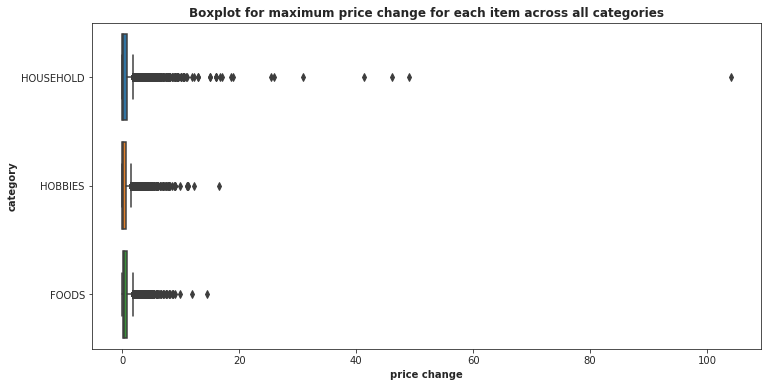

In [91]:
plt.figure(figsize=(12,6))
sns.boxplot(x="price_change", y= "category", data=item_store_prices_sorted)
plt.xlabel("price change",fontweight='bold')
plt.ylabel("category",fontweight='bold')
title=plt.title("Boxplot for maximum price change for each item across all categories",fontweight='bold')

Insights:

* Most of the products prices don't change and if they do, are restricted between 10 and 15 USD.
* As stated before, HOUSEHOLD products have the greatest changes over the years

**<span style="color:DarkCyan;"> Let's explore calendar data </span>**

In [92]:
print("The calendar dataset has {} rows and {} columns".format(calendar.shape[0],calendar.shape[1]))

The calendar dataset has 1969 rows and 17 columns


In [93]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,rainfall_texas(mm),rainfall_wisconsin(mm),rainfall_cal(mm)
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0.06383,0.0,0.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0.35653,0.0,7.2
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0.65826,1.6,0.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,7.83312,2.7,0.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0.00025,3.4,0.0


**What we know:**

* We have at max 2 events in a day for which the event names and the event types are given
* There are SNAP days.

**But what is SNAP?**

After some google searching, SNAP stands for the Supplemental Nutrition Assistance Program. SNAP is a federal program that helps millions of low-income Americans put food on the table. Across the United States there are 9.5 million families with children on SNAP. It is the largest program working to fight hunger in America.

**What kinds of groceries can be purchased with SNAP?**
Households can use SNAP to buy nutritious foods such as breads and cereals, fruits and vegetables, meat and fish and dairy products. SNAP benefits **cannot be used** to buy any kind of alcohol or tobacco products or **any nonfood items like household supplies** and vitamins and medicines. Obviously, we can assume that SNAP promotes the FOODS sales.


ref:https://www.feedingamerica.org/take-action/advocate/federal-hunger-relief-programs/snap

**<span style="color:DarkCyan;"> Event Data </span>**

In [94]:
# Event names for each event type
events1 = calendar[['event_type_1','event_name_1',]] #get the first duo
events2 = calendar[['event_type_2','event_name_2',]] # get the 2nd duo
events2.columns = ["event_type_1","event_name_1"] #
events = pd.concat([events1,events2],ignore_index = True) #concat the two dfs
events = events.dropna().drop_duplicates() # Get rid of duplicates
events_dict = {k: g["event_name_1"].tolist() for k,g in events.groupby("event_type_1")} # Events names to list and groupby event_type_1
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in events_dict.items()])).fillna("-") # Dataframe for all the events
#ref:https://www.geeksforgeeks.org/python-program-to-swap-keys-and-values-in-dictionary/

,Cultural,National,Religious,Sporting
0,ValentinesDay,PresidentsDay,LentStart,SuperBowl
1,StPatricksDay,MemorialDay,LentWeek2,NBAFinalsStart
2,Cinco De Mayo,IndependenceDay,Purim End,NBAFinalsEnd
3,Mother's day,LaborDay,OrthodoxEaster,-
4,Father's day,ColumbusDay,Pesach End,-
5,Halloween,VeteransDay,Ramadan starts,-
6,Easter,Thanksgiving,Eid al-Fitr,-
7,-,Christmas,EidAlAdha,-
8,-,NewYear,Chanukah End,-
9,-,MartinLutherKingDay,OrthodoxChristmas,-


There are 10 National and Religious events, 6 Cultural Events and 3 Sporting events(30 events in total)



**<span style="color:DarkCyan;"> Let's explore the SNAP feature data </span>**

In [95]:
snap_days=calendar.groupby(['year','month'])['snap_CA','snap_TX','snap_WI'].sum().reset_index()
snap_days
print("SNAP days for each month across the years for all the states")
snap_days.pivot(index="month",columns = "year",values = ["snap_CA","snap_TX","snap_WI"]).fillna("-")

SNAP days for each month across the years for all the states


snap_CA                              snap_TX                          \
year     2011  2012  2013  2014  2015 2016    2011  2012  2013  2014  2015   
month                                                                        
1         0.0  10.0  10.0  10.0  10.0   10     0.0  10.0  10.0  10.0  10.0   
2        10.0  10.0  10.0  10.0  10.0   10    10.0  10.0  10.0  10.0  10.0   
3        10.0  10.0  10.0  10.0  10.0   10    10.0  10.0  10.0  10.0  10.0   
4        10.0  10.0  10.0  10.0  10.0   10    10.0  10.0  10.0  10.0  10.0   
5        10.0  10.0  10.0  10.0  10.0   10    10.0  10.0  10.0  10.0  10.0   
6        10.0  10.0  10.0  10.0  10.0   10    10.0  10.0  10.0  10.0  10.0   
7        10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   
8        10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   
9        10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   
10       10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   
11       10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   
12       10.0  10.0  10.0  10.0  10.0    -    10.0  10.0  10.0  10.0  10.0   

           snap_WI                               
year  2016    2011  2012  2013  2014  2015 2016  
month                                            
1       10     0.0  10.0  10.0  10.0  10.0   10  
2       10    10.0  10.0  10.0  10.0  10.0   10  
3       10    10.0  10.0  10.0  10.0  10.0   10  
4       10    10.0  10.0  10.0  10.0  10.0   10  
5       10    10.0  10.0  10.0  10.0  10.0   10  
6       10    10.0  10.0  10.0  10.0  10.0   10  
7        -    10.0  10.0  10.0  10.0  10.0    -  
8        -    10.0  10.0  10.0  10.0  10.0    -  
9        -    10.0  10.0  10.0  10.0  10.0    -  
10       -    10.0  10.0  10.0  10.0  10.0    -  
11       -    10.0  10.0  10.0  10.0  10.0    -  
12       -    10.0  10.0  10.0  10.0  10.0    -

Apparently, there are 10 SNAP days for each state every month. That pattern is consistent across all years examined.



## **<span style="color:DarkCyan;"> Time series </span>**

**<span style="color:DarkCyan;"> Across years </span>**

In [96]:
import datetime
#Setting the start date
start = datetime.datetime(2011,1,29) #starting day
#Calculating the total sales in a day
sales_sum = pd.DataFrame(train[day_col].sum(axis =0),columns = ["sales"])
#Adding the date column
sales_sum['date1'] = [start + datetime.timedelta(days=x) for x in range(1969)] #ref: https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
sales_sum.set_index('date1', drop=True, inplace=True)
sales_sum.sort_index(inplace=True)

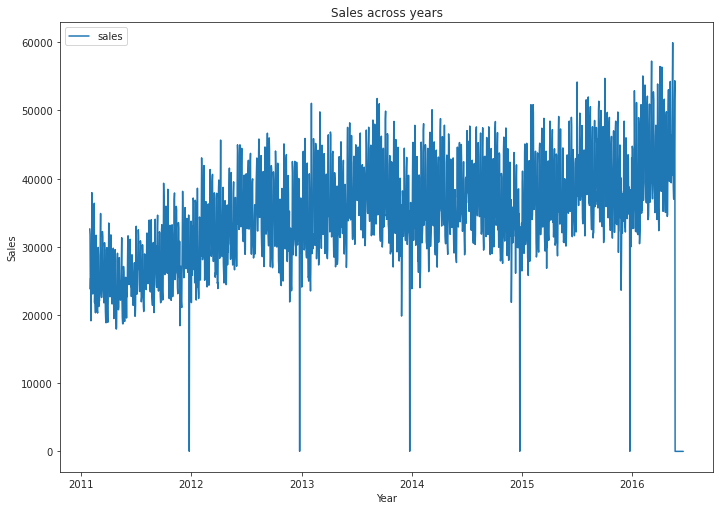

In [97]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax=sns.lineplot(data=sales_sum)
ax.set(xlabel='Year', ylabel='Sales')
plt.title("Sales across years")
plt.show()


* We observe an increasing overall trend


**A time series can be thought of as being made up of 4 components:**
* A seasonal component
* A trend component
* A cyclical component, and
* A noise component.

ref: https://towardsdatascience.com/what-is-time-series-decomposition-and-how-does-it-work-9b67e007ae90

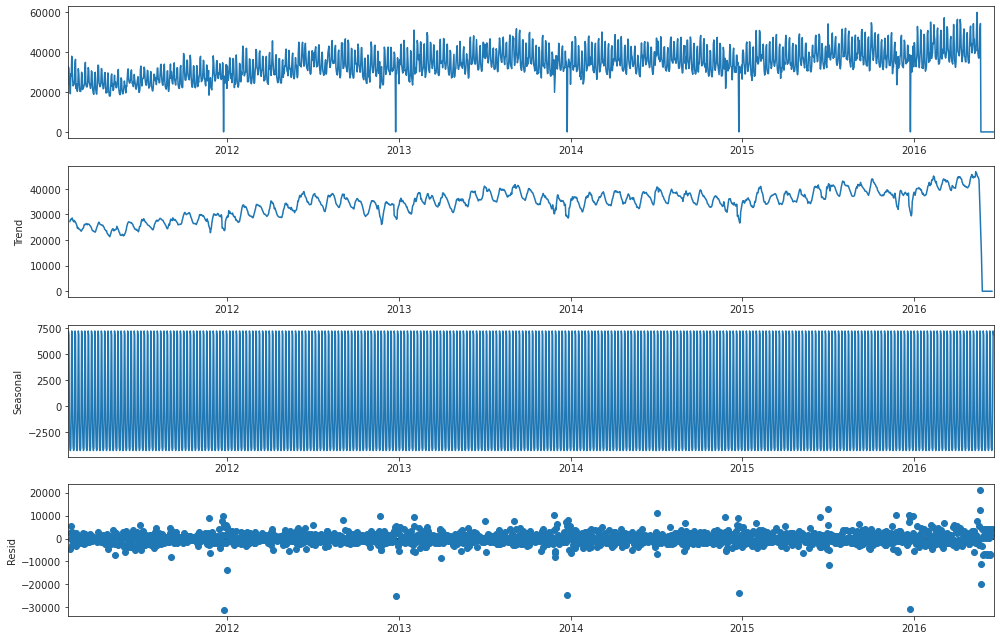

In [98]:
import pylab as pl
result= seasonal_decompose(sales_sum, model='additive')
pl.rcParams['figure.figsize'] = (14, 9)
result.plot()
pl.show()


**After the decomposition we get:**

* The first graph shows the actual time series
* The second graph shows the trend. The overall trend seems to be increasing over the years
* The third graph shows the seasonality. We see a weekly/monthly
* We also see a few  residuals in the last graph,meaning that there are "errors" that aren’t explained by the regression line.

In [99]:
del train, calendar, sample, sell_prices

# **<span style="color:DarkCyan;"> Create single dataset(melt and merge) </span>**

<img src="https://33.media.tumblr.com/f6d253eff4ed0701713e4f4df06bead4/tumblr_nhpzm2MsRf1qzeylbo1_r1_500.gif">

In [100]:
import pandas as pd
# Load the Data
train= pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')
submission = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sample_submission.csv")


In [101]:
options = train['item_id'].unique()

In [102]:
#Create drop_down list for user to select item 

#To be able to select new items we use jupyter widget 
train= pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
import ipywidgets as widgets
from IPython.display import display, clear_output
selected_variable = widgets.Dropdown(
    options=options,
    value=options[0],
    description='Select item:',
    disabled=False,
    button_style=''
)
display(selected_variable)
#ref: https://stackoverflow.com/questions/41018240/jupyter-dropdown-widget-trigger-action

Dropdown(description='Select item:', options=('HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', 'HOBBIES_1_00…

In [103]:
#Dataset filtered based on the selected item
tr=train[train['item_id']== selected_variable.value]
tr

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
3049   HOBBIES_1_001_CA_2_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
6098   HOBBIES_1_001_CA_3_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
9147   HOBBIES_1_001_CA_4_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
12196  HOBBIES_1_001_TX_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
15245  HOBBIES_1_001_TX_2_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
18294  HOBBIES_1_001_TX_3_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
21343  HOBBIES_1_001_WI_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
24392  HOBBIES_1_001_WI_2_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
27441  HOBBIES_1_001_WI_3_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   

      store_id state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  \
0         CA_1       CA    0    0    0    0    0    0    0    0    0     0   
3049      CA_2       CA    0    0    0    0    0    0    0    0    0     0   
6098      CA_3       CA    0    0    0    0    0    0    0    0    0     0   
9147      CA_4       CA    0    0    0    0    0    0    0    0    0     0   
12196     TX_1       TX    0    0    0    0    0    0    0    0    0     0   
15245     TX_2       TX    0    0    0    0    0    0    0    0    0     0   
18294     TX_3       TX    0    0    0    0    0    0    0    0    0     0   
21343     WI_1       WI    0    0    0    0    0    0    0    0    0     0   
24392     WI_2       WI    0    0    0    0    0    0    0    0    0     0   
27441     WI_3       WI    0    0    0    0    0    0    0    0    0     0   

       d_11  d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
3049      0     0     0     0     0     0     0     0     0     0     0     0   
6098      0     0     0     0     0     0     0     0     0     0     0     0   
9147      0     0     0     0     0     0     0     0     0     0     0     0   
12196     0     0     0     0     0     0     0     0     0     0     0     0   
15245     0     0     0     0     0     0     0     0     0     0     0     0   
18294     0     0     0     0     0     0     0     0     0     0     0     0   
21343     0     0     0     0     0     0     0     0     0     0     0     0   
24392     0     0     0     0     0     0     0     0     0     0     0     0   
27441     0     0     0     0     0     0     0     0     0     0     0     0   

       d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
3049      0     0     0     0     0     0     0     0     0     0     0     0   
6098      0     0     0     0     0     0     0     0     0     0     0     0   
9147      0     0     0     0     0     0     0     0     0     0     0     0   
12196     0     0     0     0     0     0     0     0     0     0     0     0   
15245     0     0     0     0     0     0     0     0     0     0     0     0   
18294     0     0     0     0     0     0     0     0     0     0     0     0   
21343     0     0     0     0     0     0     0     0     0     0     0     0   
24392     0     0     0     0     0     0     0     0     0     0     0     0   
27441     0     0     0     0     0     0     0     0     0     0     0     0   

       d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  \
0         0     0     0     0     0     0     0     0     0     0     0     0   
3049      0     0     0     0     0     0     0     0     0     0     0     0   
6098      0     0     0     0     0     0     0     0     0     0     0     0   
9147      0     0     0     0     0     0     0     0     0     0     0     0   
12196     0     0     0     0     0     0     0     0     0     0     0     0   
15245     0     0     0     0     0     0     0     0     0     0     0     0  

In [104]:
#load amount of rainfall in mm for the 3 states----> For another notebook
#data from : https://climate.northwestknowledge.net/NWTOOLBOX/formattedDownloads.php?fbclid=IwAR2NDiDae2B_BR13Ba8CQC_fN3ENudhdKVeyoeno1vE6vE0b_DbAJwA3Ntw
#tx_rain=pd.read_excel('../input/rainfall2/TexasExcel.xlsx')
#cal_rain=pd.read_excel('../input/rainfall2/California.xlsx')
#wi_rain=pd.read_excel('../input/rainfall2/WisconsinExcel.xlsx')

**<span style="color:DarkCyan;"> We start by converting the train dataframe from wide to long format </span>**

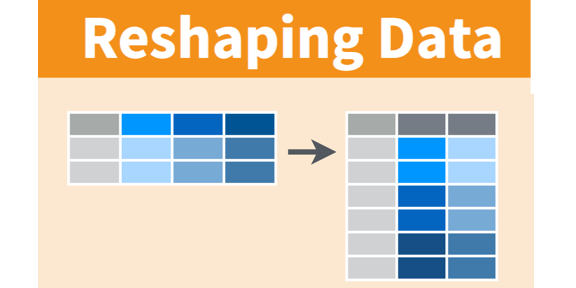

In [105]:
#melt data
melt_df = pd.melt(tr, 
                  id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                  var_name = 'd', 
                  value_name = "sales").dropna()

In [106]:
melt_df.head()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0
2,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0
3,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0
4,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0


In [107]:
#merge the melted train dataframe with calendar df on column d(the common column)
train_cal= pd.merge(melt_df,calendar, on='d', how = "left")
train_cal.head(50)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
5,HOBBIES_1_001_TX_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
6,HOBBIES_1_001_TX_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
7,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
8,HOBBIES_1_001_WI_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
9,HOBBIES_1_001_WI_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [108]:
import gc
gc.collect()

17431

In [109]:
#merge the train_cal df(combination of train and calendar DFs with sell_prices df on store_id,item_id and wm_yr_wk columns
single = pd.merge(train_cal, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left') 


In [110]:
single.head(20)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_001_CA_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_001_CA_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_001_CA_4_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_001_TX_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
5,HOBBIES_1_001_TX_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
6,HOBBIES_1_001_TX_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
7,HOBBIES_1_001_WI_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
8,HOBBIES_1_001_WI_2_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
9,HOBBIES_1_001_WI_3_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


# **<span style="color:DarkCyan;"> Feature Engineering-Data preprocessing </span>**



In [111]:
#Fill na values with "unknown"
na_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in na_features:
        single[feature].fillna('unknown', inplace = True)

In [112]:
#Encoding the categorical features
from sklearn import preprocessing, metrics
categorical = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in categorical:
    encoder = preprocessing.LabelEncoder()
    single[feature] = encoder.fit_transform(single[feature])

**<span style="color:DarkCyan;"> Time features </span>**

In [113]:
# time features
single['date'] = pd.to_datetime(single['date'])
single['month'] = single['date'].dt.month
single['week'] = single['date'].dt.week
single['day'] = single['date'].dt.day
single['dayofweek'] = single['date'].dt.dayofweek
single["is_weekend"] = single["dayofweek"].isin([5, 6]).astype(np.int8)

In [114]:
#function to retrieve the season
def get_season(x):
    if x in [12,1,2]:
        return 0      #"Winter"
    elif x in [3,4,5]:
        return 1   #"Spring"
    elif x in [6,7,8]:
        return 2   #"Summer"
    else:
        return 3   #Autumn


#Get the season
single['season']=single['month'].apply(lambda x:get_season(x))    

In [115]:
single.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19410 entries, 0 to 19409
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            19410 non-null  object        
 1   item_id       19410 non-null  int64         
 2   dept_id       19410 non-null  int64         
 3   cat_id        19410 non-null  int64         
 4   store_id      19410 non-null  int64         
 5   state_id      19410 non-null  int64         
 6   d             19410 non-null  object        
 7   sales         19410 non-null  int64         
 8   date          19410 non-null  datetime64[ns]
 9   wm_yr_wk      19410 non-null  int64         
 10  weekday       19410 non-null  object        
 11  wday          19410 non-null  int64         
 12  month         19410 non-null  int64         
 13  year          19410 non-null  int64         
 14  event_name_1  19410 non-null  int64         
 15  event_type_1  19410 non-null  int64 

In [116]:
single.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,week,day,dayofweek,is_weekend,season
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,NaN,4,29,5,1,0
1,HOBBIES_1_001_CA_2_evaluation,0,0,0,1,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,NaN,4,29,5,1,0
2,HOBBIES_1_001_CA_3_evaluation,0,0,0,2,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,NaN,4,29,5,1,0
3,HOBBIES_1_001_CA_4_evaluation,0,0,0,3,0,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,NaN,4,29,5,1,0
4,HOBBIES_1_001_TX_1_evaluation,0,0,0,4,1,d_1,0,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,NaN,4,29,5,1,0


In [117]:
# going to evaluate with the last 28 days
X_train = single[single['date'] <= '2016-03-27']
X_train.drop(['id','date','d','weekday'], axis=1, inplace=True)
y_train = X_train['sales']
X_val = single[(single['date'] > '2016-03-27') & (single['date'] <= '2016-04-24')]
y_val = X_val['sales']
test = single[(single['date'] > '2016-04-24')]
gc.collect()

0

In [118]:
# define list of features
features= ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price','season','is_weekend']

In [119]:
lgtrain= lgb.Dataset(X_train[features], label=y_train)
lgval = lgb.Dataset(X_val[features], label=y_val)

In [120]:
#random hyperparameters
params ={'boosting_type': 'gbdt',
 'objective': 'regression',
 'colsample_bytree': 1.0,
 'metric':'rmse',
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'num_leaves': 31,
 'random_state': 500,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# Initiate classifier to use
model = lgb.LGBMRegressor(boosting_type= 'gbdt', 
          objective = 'regression', 
          n_jobs = 5, 
          silent = True,
          max_bin=255,                
          max_depth = params['max_depth'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])

# To view the default model parameters:
model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin'])

In [121]:
#Grid Search to select best hyperparameters
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_jobs':[-1,1],
    'num_leaves': [6,8], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['regression','tweedie'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.70],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4]}

grid = GridSearchCV(model, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X_train[features], y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 1536 candidates, totalling 6144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 6144 out of 6144 | elapsed: 11.9min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_bin': 255, 'n_jobs': -1, 'num_leaves': 8, 'objective': 'tweedie', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7}
0.02610948743919994


In [122]:
''''
#Used some params from the Gridsearch and some randomly with trial and error
params={'boosting_type': 'gbdt',
        'colsample_bytree': 0.75,
        'learning_rate': 0.1,
        'max_bin': 255,
        'n_jobs': -1,
        'num_leaves': 8,
        'objective': 'regression',
        'metric': 'rmse',
        'random_state': 236,
        'reg_alpha': 1,
        'reg_lambda': 1,
        'subsample': 0.7}
        '''

"'\n#Used some params from the Gridsearch and some randomly with trial and error\nparams={'boosting_type': 'gbdt',\n        'colsample_bytree': 0.75,\n        'learning_rate': 0.1,\n        'max_bin': 255,\n        'n_jobs': -1,\n        'num_leaves': 8,\n        'objective': 'regression',\n        'metric': 'rmse',\n        'random_state': 236,\n        'reg_alpha': 1,\n        'reg_lambda': 1,\n        'subsample': 0.7}\n        "

Training until validation scores don't improve for 50 rounds
[100]	training's tweedie: 1.46242	valid_1's tweedie: 2.90689
[200]	training's tweedie: 1.33662	valid_1's tweedie: 2.83827
[300]	training's tweedie: 1.28792	valid_1's tweedie: 2.83395
Early stopping, best iteration is:
[252]	training's tweedie: 1.30667	valid_1's tweedie: 2.81909
Our val rmse score is 0.8251220902121071


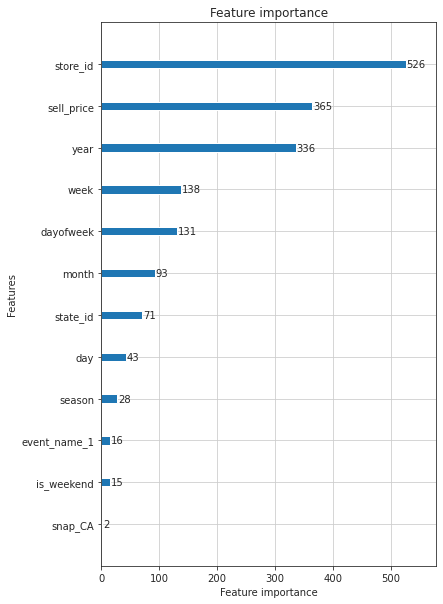

In [123]:
# model estimation
model = lgb.train(grid.best_params_, lgtrain, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [lgtrain, lgval], verbose_eval = 100)
val_pred = model.predict(X_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
print(f'Our val rmse score is {val_score}')
y_pred = model.predict(test[features])
test['sales'] = y_pred
# plot feature importance 
lgb.plot_importance(model,importance_type="split" , figsize=(6, 10))

In [124]:
predictions = test[['id', 'date', 'sales']]
predictions = pd.pivot(predictions, index = 'id', columns = 'date', values = 'sales').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]
predictions

validation = submission[['id']].merge(predictions, on = 'id')
final = validation
final.sort_index(axis=1)
final.to_csv('submission.csv', index = False)
final
    

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.495427,0.495427,0.495427,0.494767,0.488703,0.480845,0.473811,0.494380,0.494380,0.494380,0.449149,0.487670,0.512977,0.466666,0.494380,0.494380,0.495427,0.494767,0.488703,0.519380,0.519380,0.495427,0.495427,0.495427,0.494767,0.488703,0.520593,0.520593
1,HOBBIES_1_001_CA_2_evaluation,0.495427,0.495427,0.495427,0.494767,0.488703,0.480845,0.473811,0.494380,0.494380,0.494380,0.449149,0.487670,0.512977,0.466666,0.494380,0.494380,0.495427,0.494767,0.488703,0.519380,0.519380,0.495427,0.495427,0.495427,0.494767,0.488703,0.520593,0.520593
2,HOBBIES_1_001_CA_3_evaluation,0.537051,0.537051,0.537051,0.534926,0.528370,0.504731,0.497348,0.535916,0.535916,0.535916,0.485605,0.527254,0.538460,0.489848,0.535916,0.535916,0.537051,0.534926,0.528370,0.545181,0.545181,0.537051,0.537051,0.537051,0.534926,0.528370,0.546453,0.546453
3,HOBBIES_1_001_CA_4_evaluation,0.535251,0.535251,0.535251,0.533134,0.526600,0.503041,0.495682,0.534121,0.534121,0.534121,0.483979,0.525488,0.536656,0.488207,0.534121,0.534121,0.535251,0.533134,0.526600,0.543355,0.543355,0.535251,0.535251,0.535251,0.533134,0.526600,0.544623,0.544623
4,HOBBIES_1_001_TX_1_evaluation,0.283165,0.283165,0.283165,0.293044,0.304926,0.322475,0.314867,0.282567,0.282567,0.282567,0.285927,0.304282,0.314867,0.314867,0.282567,0.282567,0.283165,0.286532,0.304926,0.321724,0.321724,0.283165,0.283165,0.283165,0.286532,0.304926,0.322475,0.322475
5,HOBBIES_1_001_TX_2_evaluation,0.392974,0.392974,0.392974,0.404596,0.421001,0.445231,0.434727,0.392144,0.392144,0.392144,0.394770,0.420112,0.434727,0.434727,0.392144,0.392144,0.392974,0.395606,0.421001,0.444194,0.444194,0.392974,0.392974,0.392974,0.395606,0.421001,0.445231,0.445231
6,HOBBIES_1_001_TX_3_evaluation,0.392974,0.392974,0.392974,0.404596,0.421001,0.445231,0.434727,0.392144,0.392144,0.392144,0.394770,0.420112,0.434727,0.434727,0.392144,0.392144,0.392974,0.395606,0.421001,0.444194,0.444194,0.392974,0.392974,0.392974,0.395606,0.421001,0.445231,0.445231
7,HOBBIES_1_001_WI_1_evaluation,0.141258,0.141258,0.141258,0.146403,0.188978,0.205336,0.205064,0.145573,0.145573,0.145573,0.145298,0.194751,0.205064,0.201971,0.145573,0.145573,0.145881,0.147835,0.195164,0.207624,0.207624,0.145881,0.145881,0.145881,0.147835,0.195164,0.207624,0.207624
8,HOBBIES_1_001_WI_2_evaluation,0.130148,0.130148,0.130148,0.134888,0.176510,0.195829,0.195939,0.134377,0.134377,0.134377,0.134123,0.182246,0.195939,0.192984,0.134377,0.134377,0.134407,0.136208,0.182287,0.198011,0.198011,0.134407,0.134407,0.134407,0.136208,0.182287,0.198011,0.198011
9,HOBBIES_1_001_WI_3_evaluation,0.149173,0.149173,0.149173,0.154606,0.199689,0.213400,0.211167,0.149138,0.149138,0.149138,0.148857,0.199644,0.211167,0.207982,0.149138,0.149138,0.149173,0.151171,0.199689,0.213400,0.213400,0.149173,0.149173,0.149173,0.151171,0.199689,0.213400,0.213400
